In [1]:
import numpy as np
import cirq
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from openparticle import ParticleOperator, Fock
from openparticle.utils import generate_matrix, get_fock_basis
import math
from functools import reduce, partial
from symmer import QuantumState

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../'))

from src.lobe.fermionic import fermionic_product_block_encoding, fermionic_plus_hc_block_encoding
from src.lobe.system import System
from src.lobe.metrics import CircuitMetrics
from src.lobe.multiplexed_rotations import get_decomposed_multiplexed_rotation_circuit
from src.lobe._utils import _apply_negative_identity, get_basis_of_full_system, get_fermionic_operator_types, pretty_print
from src.lobe.bosonic import _get_bosonic_rotation_angles, _add_multi_bosonic_rotations
from src.lobe.addition import add_classical_value
from src.lobe.decompose import decompose_controls_left, decompose_controls_right
from src.lobe.index import index_over_terms
from src.lobe.asp import add_prepare_circuit, get_target_state
from src.lobe.reflection import add_ancilla_reflection
from src.lobe.qpe_utils import *

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [128]:
hamiltonian_operator = (
    ParticleOperator('b0^ b0')
)

coefficient_vector = [term.coeff if len(term) == 1 else term.coeffs[0] for term in hamiltonian_operator.group()]
rescaling_factor = np.linalg.norm(coefficient_vector, 1)
basis = get_basis_of_full_system(1, 2, 0)
H_matrix = generate_matrix(hamiltonian_operator, basis)


n_index_qubits = int(max(
    np.ceil(np.log2(len(hamiltonian_operator.group()))), 1
    ))
n_clean_ancilla = 2 
n_be_ancilla = 1 #Fixed for fermionic BE's
n_system_qubits = hamiltonian_operator.max_fermionic_mode + 1
n_qubits = n_index_qubits + n_clean_ancilla + n_be_ancilla + n_system_qubits

qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
index_register = qubits[:n_index_qubits]
clean_ancilla_register = qubits[n_index_qubits: n_index_qubits + n_clean_ancilla]
block_encoding_ancilla_register = qubits[n_index_qubits + n_clean_ancilla:n_index_qubits + n_clean_ancilla + n_be_ancilla]
system_register = System(1, 
                        len(index_register) + len(clean_ancilla_register) + len(block_encoding_ancilla_register), 
                        hamiltonian_operator.max_mode + 1, 0)

target_state = get_target_state(coefficients=coefficient_vector)
print(index_register, clean_ancilla_register, block_encoding_ancilla_register, system_register.fermionic_modes)

if len(hamiltonian_operator.group()) < 2:
        PREPARE = [cirq.X.on(index_register[0])]
        PREPARE_DAGGER = [cirq.X.on(index_register[0])]
else:
    PREPARE = add_prepare_circuit(index_register, target_state, dagger=False, clean_ancillae=clean_ancilla_register, ctrls=([], []))[0]
    PREPARE_DAGGER = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancilla_register, ctrls=([], []))[0]


SELECT = get_select_oracle(
        operator = hamiltonian_operator,
        prepare_register=index_register,
        system = system_register,
        block_encoding_ancillae=block_encoding_ancilla_register,
        clean_ancillae=clean_ancilla_register,
        ctrls=([], )
    )[0]


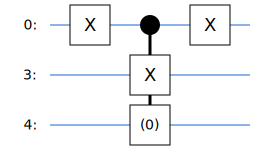

In [129]:
SVGCircuit(cirq.Circuit([PREPARE, SELECT, PREPARE_DAGGER]))

In [135]:
cirq.Circuit([PREPARE, SELECT, SELECT, PREPARE_DAGGER]).unitary()[:len(basis), :len(basis)].real * rescaling_factor

array([[1., 0.],
       [0., 1.]])

In [122]:
n_phase_bits = 6
n_index_qubits = int(np.ceil(np.log2(len(hamiltonian_operator.group()))))
n_clean_ancilla = 2 
n_be_ancilla = 1 #Fixed for fermionic BE's
n_system_qubits = hamiltonian_operator.max_fermionic_mode + 1
n_qubits = n_phase_bits + n_index_qubits + n_clean_ancilla + n_be_ancilla + n_system_qubits


qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
phase_register = qubits[:n_phase_bits]
index_register = qubits[n_phase_bits: n_phase_bits + n_index_qubits]
clean_ancilla_register = qubits[n_phase_bits + n_index_qubits: n_phase_bits + n_index_qubits + n_clean_ancilla]
block_encoding_ancilla_register = qubits[n_phase_bits + n_index_qubits + n_clean_ancilla:n_phase_bits + n_index_qubits + n_clean_ancilla + n_be_ancilla]
system_register = qubits[n_phase_bits + n_index_qubits + n_clean_ancilla + n_be_ancilla:]

circuit = cirq.Circuit()
circuit.append(cirq.I.on_each(*qubits))

for qubit in phase_register:
    circuit.append(cirq.H.on(qubit))



target_state = get_target_state(coefficients=coefficient_vector)

system = System(1, len(phase_register) + len(index_register) + len(clean_ancilla_register) + len(block_encoding_ancilla_register), hamiltonian_operator.max_mode + 1, 0)
assert system.fermionic_modes == system_register

for i, qubit in enumerate(phase_register[::-1]):
    for _ in range(1<<i):
        prepare_gates, _ = add_prepare_circuit(index_register, target_state, dagger=False, clean_ancillae=clean_ancilla_register, ctrls=([qubit], [1]))
        circuit += prepare_gates
        
        select_gates, _ = get_select_oracle(
            operator = hamiltonian_operator,
            prepare_register=index_register,
            system = system,
            block_encoding_ancillae=block_encoding_ancilla_register,
            clean_ancillae=clean_ancilla_register,
            ctrls=([qubit], [1])
        )
        circuit += select_gates

        prepare_dagger_gates, _ = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancilla_register, ctrls=([qubit], [1]))
        circuit += prepare_dagger_gates
        
        refl_gates = add_ancilla_reflection(index_register+block_encoding_ancilla_register, ctrls=([qubit], [1]))
        circuit += refl_gates

circuit.append(cirq.qft(*phase_register, inverse=True))

In [124]:
#Verify Oracles

SELECT = get_select_oracle(
    operator = hamiltonian_operator,
    prepare_register=index_register,
    system = system,
    block_encoding_ancillae=block_encoding_ancilla_register,
    clean_ancillae=clean_ancilla_register,
)[0]
PREPARE = add_prepare_circuit(index_register, target_state=target_state)[0]
REFLECT = add_ancilla_reflection(ancilla_register=index_register)
PREPARE_DAGGER = [cirq.inverse(gate) for gate in PREPARE[::-1]]

In [125]:
cirq.Circuit([PREPARE, SELECT, PREPARE_DAGGER]).unitary()[:4, :4].real * rescaling_factor

array([[0., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 1., 0.],
       [0., 0., 0., 2.]])

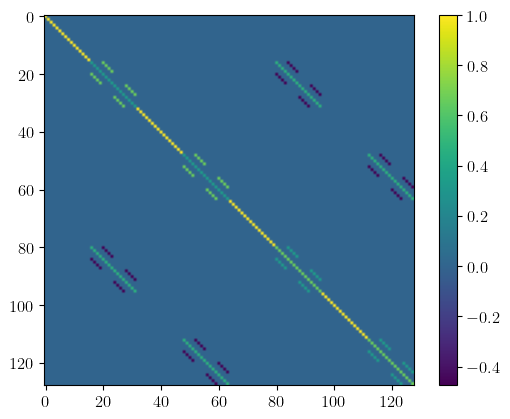

In [130]:
plt.imshow(cirq.Circuit([PREPARE, SELECT, SELECT, PREPARE_DAGGER]).unitary().real)
plt.colorbar()

In [127]:
excitation_level = 2

#Initial state 
phase_state = np.zeros(1<<n_phase_bits) 
phase_state[0] = 1 #|0>^o\times n_phase_bits

index_clean_be_anc = np.zeros(1 << (n_index_qubits + n_clean_ancilla + n_be_ancilla))
index_clean_be_anc[0] = 1
system_state = vecs[:, excitation_level]

full_initial_state = np.kron(
    phase_state.flatten(),
    np.kron(
        index_clean_be_anc.flatten(), system_state.flatten()
    )
)

print("---Initial---")
print(pretty_print(full_initial_state.flatten(), [n_phase_bits, n_index_qubits, n_clean_ancilla, n_be_ancilla, n_system_qubits], 1e-4))

state = cirq.Simulator().simulate(circuit, initial_state=full_initial_state.flatten()).final_state_vector
print("---Final---")
print(pretty_print(state, [n_phase_bits, n_index_qubits, n_clean_ancilla, n_be_ancilla, n_system_qubits], 1e-4))

---Initial---
(0.707+0j)       |000000|00|00|0|01>
(0.707+0j)       |000000|00|00|0|10>

---Final---
(0.012+0j)       |000000|00|00|0|01>
(0.012+0j)       |000000|00|00|0|10>
(0.001+0j)       |000000|00|00|1|01>
(0.001+0j)       |000000|00|00|1|10>
(0.001+0j)       |000000|01|00|0|01>
(-0.001+0j)      |000000|01|00|0|10>
(-0.001+0j)      |000000|01|00|1|01>
(0.001+0j)       |000000|01|00|1|10>
(0.001+0j)       |000000|10|00|0|01>
(0.001+0j)       |000000|10|00|0|10>
(-0.001+0j)      |000000|10|00|1|01>
(-0.001+0j)      |000000|10|00|1|10>
(-0.001+0j)      |000000|11|00|0|01>
(0.001+0j)       |000000|11|00|0|10>
(0.001+0j)       |000000|11|00|1|01>
(-0.001+0j)      |000000|11|00|1|10>
(0.012+0.001j)   |000001|00|00|0|01>
(0.012+0.001j)   |000001|00|00|0|10>
(0.001-0j)       |000001|00|00|1|01>
(0.001-0j)       |000001|00|00|1|10>
(0.001-0j)       |000001|01|00|0|01>
(-0.001+0j)      |000001|01|00|0|10>
(-0.001+0j)      |000001|01|00|1|01>
(0.001-0j)       |000001|01|00|1|10>
(0.001-0j) 

In [128]:
probabilities = simulate_circuit_and_compute_probabilities(circuit, full_initial_state, n_phase_bits)
eigenphases = list_possible_eigenphases(n_phase_bits)

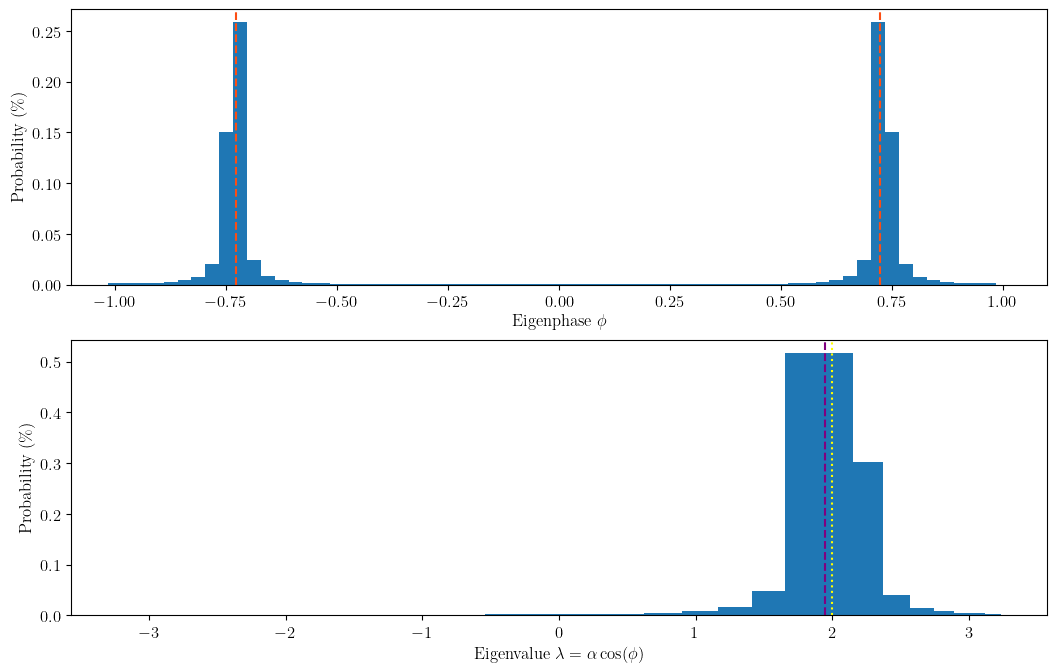

In [129]:
fig, axes = plt.subplots(2, 1, figsize=(32 / 2.54, 20 / 2.54))

# axes[0].bar(names, counts, width = 0.02)
axes[0].bar(eigenphases, probabilities, width=2/(1<<n_phase_bits))

alpha_plot_scale = 0
if n_phase_bits < 5:
    alpha_plot_scale = 0.75

for possible_eigenphase in eigenphases:
    axes[0].axvline(x = possible_eigenphase, color = 'k', linestyle = ':', alpha = alpha_plot_scale, zorder = -1)
axes[0].set_ylabel(r'Probability ($\%$)')
axes[0].set_xlabel(f"Eigenphase $\phi$")
axes[0].set_xlim(-1.1, 1.1)
# axes[0].set_ylim(0, 100)
negative_numerical_value = expected_value_of_eigenphase(eigenphases[:int(len(eigenphases)/2)], 2*probabilities[:int(len(eigenphases)/2)])
positive_numerical_value = expected_value_of_eigenphase(eigenphases[int(len(eigenphases)/2):], 2*probabilities[int(len(eigenphases)/2):])
axes[0].axvline(x=positive_numerical_value, color="#FC4E14", ls="--", label="Numerical")
axes[0].axvline(x=negative_numerical_value, color="#FC4E14", ls="--", label="Numerical")


energies = np.array([decode_eigenphase(eigenphase, rescaling_factor) for eigenphase in eigenphases]) #-1*np.cos(np.array(eigenphases)*np.pi)
parsed_energies = energies[:int(len(energies)/2) + 1]
parsed_probabilities = np.array(probabilities[:int(len(energies)/2) + 1])
for i, prob in enumerate(probabilities[int(len(energies)/2) + 1:]):
    parsed_probabilities[-2 - i] += prob
bar_plot = axes[1].bar(parsed_energies, parsed_probabilities, width=32/(1<<n_phase_bits))

axes[1].set_ylabel(r'Probability ($\%$)')
axes[1].set_xlabel(r"Eigenvalue $\lambda = \alpha \cos(\phi)$")

estimated_energy = np.average(
    [decode_eigenphase(positive_numerical_value, rescaling_factor),
    decode_eigenphase(negative_numerical_value, rescaling_factor)]
)
axes[1].axvline(x=estimated_energy, color="purple", ls="--", label="Numerical Average")
axes[1].axvline(x=vals[excitation_level], color="yellow", ls=":", label="Analytical Expectation")

# axes[0].set_title(f"$|E> = {QuantumState.from_array(vecs[:, excitation_level].reshape(-1, 1))}, E = {vals[excitation_level].round(3)}, \\arccos (-E/\\alpha) = {(np.arccos(-rescaled_vals[excitation_level])/np.pi).round(3)} \\pi$")
